<a href="https://colab.research.google.com/github/Nishlesh/Monte-carlo/blob/main/Copy_of_Bull_Spread_strategy_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     Strike_1  Strike_2  Max_Profit  Max_Loss  Reward_Risk_Ratio  \
0     25000.0   25050.0      175.00   1075.00           0.162791   
1     25000.0   25100.0      552.50   1947.50           0.283697   
2     25000.0   25150.0     1098.75   2651.25           0.414427   
3     25000.0   25200.0     1633.75   3366.25           0.485332   
4     25000.0   25250.0     2283.75   3966.25           0.575796   
..        ...       ...         ...       ...                ...   
103   24600.0   25500.0     8871.25  13628.75           0.650922   
104   25400.0   25450.0      842.50    407.50           2.067485   
105   25400.0   25500.0     1515.00    985.00           1.538071   
106   25450.0   25500.0      672.50    577.50           1.164502   
107   24500.0   25500.0     9275.00  15725.00           0.589825   

     Probability_of_Profit  
0                 0.583562  
1                 0.583691  
2                 0.583712  
3                 0.583758  
4                 0.583748  
..       

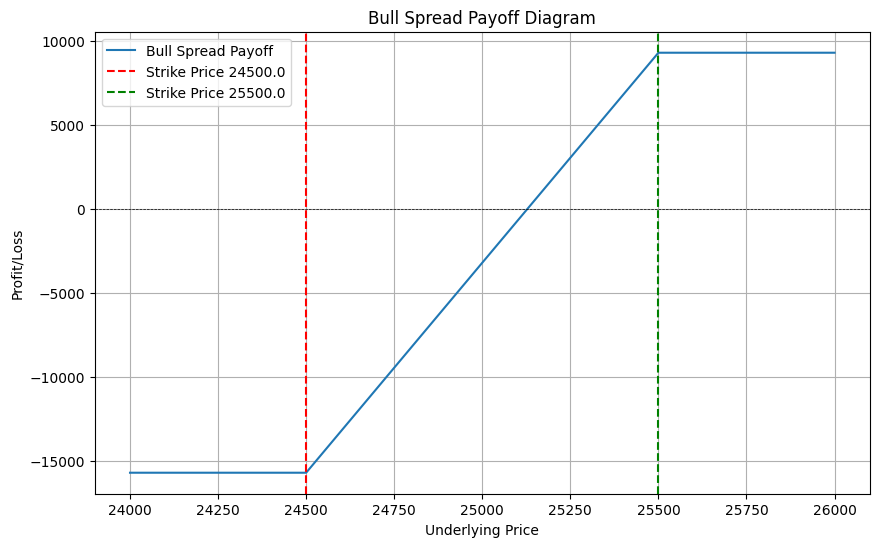

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-31-Oct-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].replace('-', np.nan)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS']/100
# Define constants
S0 = 25014.6  # Current price of NIFTY
T = 27 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:20]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Generate all possible bull spread combinations
bull_spreads = list(itertools.combinations(nearest_strikes, 2))
strategies = []

for (K1, K2) in bull_spreads:
    if K1 < K2:
        call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
        call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

        # Calculate max profit, max loss, reward/risk ratio, and probability of profit
        max_profit = (K2 - K1) - (call_price_1 - call_price_2)
        max_loss = call_price_1 - call_price_2
        reward_risk_ratio = max_profit / max_loss

        # Assuming probability of profit based on ATM strike and distance between strikes
        prob_profit = norm.cdf((np.log(S0 / K1) + (r - 0.5 * ((df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]+df_nearest[df_nearest['STRIKE'] == K2]['IV_CALLS'].values[0])/2) ** 2) * T) / ((df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]+df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]) * np.sqrt(T)/2))

        strategies.append({
            'Strike_1': K1,
            'Strike_2': K2,
            'Max_Profit': max_profit * lot_size,
            'Max_Loss': max_loss * lot_size,
            'Reward_Risk_Ratio': reward_risk_ratio,
            'Probability_of_Profit': prob_profit
        })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print(strategies_df)
# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Reward_Risk_Ratio': 0.2,
    'Probability_of_Profit': 0.6,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Reward_Risk_Ratio', 'Probability_of_Profit', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]
print(f"Top Bull Spread Strategy:\n{top_strategy}")

# Plot payoff graph for the top strategy
K1 = top_strategy['Strike_1']
K2 = top_strategy['Strike_2']
call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(min(K1, K2) - 500, max(K1, K2) + 500, 1000)

# Payoff function for the bull spread strategy
# Payoff function for the bull spread strategy
payoff = 25*np.where(
    S_range <= K1,
    -call_price_1 + call_price_2,
    np.where(
        (S_range > K1) & (S_range <= K2),
        S_range - K1 - call_price_1 + call_price_2,
        K2 - K1 - call_price_1 + call_price_2  # Payoff when S_range > K2
    )
)

# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Bull Spread Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K1, color='r', linestyle='--', label=f'Strike Price {K1}')
plt.axvline(K2, color='g', linestyle='--', label=f'Strike Price {K2}')
plt.title('Bull Spread Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-29-b41b672ec495>:64: RuntimeWarning: divide by zero encountered in log
  norm.cdf((np.log(BEP1 / S0) + (r - 0.5 * iv_avg**2) * T) / (iv_avg * np.sqrt(T)))


    Strike_1  Strike_2  Max_Profit  Max_Loss_99CI  Reward_Risk_Ratio  \
0    25000.0   25050.0    11050.00   59958.542233           0.007372   
1    25000.0   25100.0    10555.00   56963.542233           0.007412   
2    25000.0   25150.0    10397.50   54306.042233           0.007658   
3    25000.0   25200.0    10217.50   51626.042233           0.007917   
4    24950.0   25050.0    11783.75   59442.292233           0.007930   
5    24950.0   25100.0    11288.75   56447.292233           0.007999   
6    24950.0   25150.0    11131.25   53789.792233           0.008278   
7    24950.0   25200.0    10951.25   51109.792233           0.008571   
8    25050.0   25100.0    10380.00   58038.542233           0.007154   
9    25050.0   25150.0    10222.50   55381.042233           0.007383   
10   25050.0   25200.0    10042.50   52701.042233           0.007622   
11   24900.0   25100.0    11755.00   55663.542233           0.008447   
12   24900.0   25150.0    11597.50   53006.042233           0.00

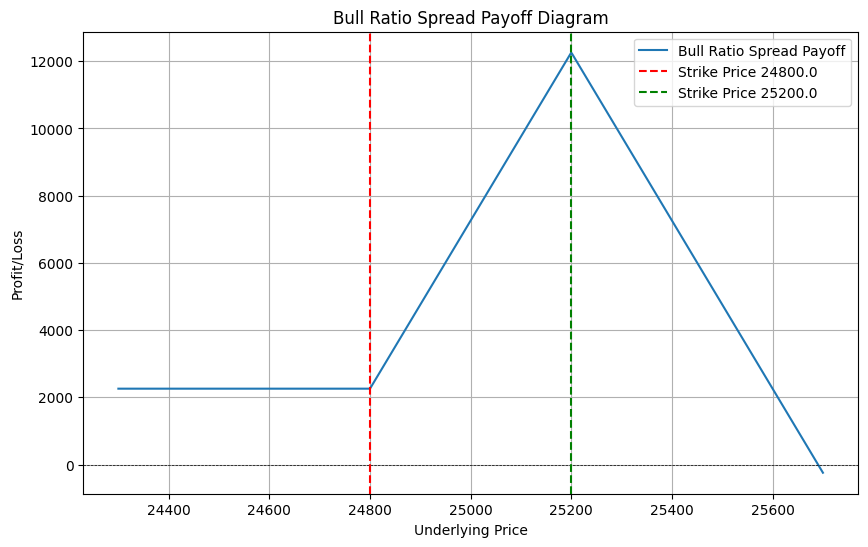

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-31-Oct-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].replace('-', np.nan)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS']/100
# Define constants
S0 = 25014.6  # Current price of NIFTY
T = 27 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Generate all possible bull ratio spread combinations
bull_ratio_spreads = list(itertools.combinations(nearest_strikes, 2))
strategies = []

# Implied volatility of the ATM strike
ATM_IV = df_nearest[df_nearest['STRIKE'] == ATM_strike]['IV_CALLS'].values[0]

# Calculate 99% confidence interval max loss
upper_bound_price_99CI = S0 + 2.33 * ATM_IV * S0* np.sqrt(T)

for (K1, K2) in bull_ratio_spreads:
    if K1 < K2:
        call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
        call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

        # Calculate max profit, max loss, reward/risk ratio
        max_profit = (K2 - K1) - (call_price_1 - 2 * call_price_2)
        max_loss_99CI = (upper_bound_price_99CI - K2 - (call_price_1 - 2 * call_price_2)) * lot_size
        reward_risk_ratio = max_profit / max_loss_99CI if max_loss_99CI != 0 else np.nan

        # Break-even points
        BEP1 = K1 + (call_price_1 - 2 * call_price_2)
        if(BEP1 < K1):
          BEP1 = 0
        BEP2 = 2 * K2 - K1 - (call_price_1 - 2 * call_price_2)

        # Probability of profit: Between BEP1 and BEP2 using cumulative normal distribution
        iv_avg = (df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0] +
                  df_nearest[df_nearest['STRIKE'] == K2]['IV_CALLS'].values[0]) / 2

        prob_profit = norm.cdf((np.log(BEP2 / S0) + (r - 0.5 * iv_avg**2) * T) / (iv_avg * np.sqrt(T))) - \
                      norm.cdf((np.log(BEP1 / S0) + (r - 0.5 * iv_avg**2) * T) / (iv_avg * np.sqrt(T)))

        strategies.append({
            'Strike_1': K1,
            'Strike_2': K2,
            'Max_Profit': max_profit * lot_size,
            'Max_Loss_99CI': max_loss_99CI,
            'Reward_Risk_Ratio': reward_risk_ratio,
            'Probability_of_Profit': prob_profit,
            'BEP1': BEP1,
            'BEP2': BEP2
        })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print(strategies_df)

# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Reward_Risk_Ratio': 0.5,
    'Probability_of_Profit': 0.3,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Reward_Risk_Ratio', 'Probability_of_Profit', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]
print(f"Top Bull Ratio Spread Strategy:\n{top_strategy}")

# Plot payoff graph for the top strategy
K1 = top_strategy['Strike_1']
K2 = top_strategy['Strike_2']
call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(min(K1, K2) - 500, max(K1, K2) + 500, 1000)


payoff = 25 * np.where(
    S_range <= K1,
    -call_price_1 + 2 * call_price_2,
    np.where(
        (S_range > K1) & (S_range <= K2),
        S_range - K1 - call_price_1 + 2 * call_price_2,
        # For S_range > K2
        -2 * (S_range - K2) - call_price_1 + 2 * call_price_2 + S_range - K1  # Payoff when S > K2
    )
)


# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Bull Ratio Spread Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K1, color='r', linestyle='--', label=f'Strike Price {K1}')
plt.axvline(K2, color='g', linestyle='--', label=f'Strike Price {K2}')
plt.title('Bull Ratio Spread Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
upper_bound_price_99CI

27056.34168933276

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from scipy.stats import norm

# Load the data
file_path = '/content/option-chain-ED-NIFTY-31-Oct-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].replace('-', np.nan)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'] / 100

# Define constants
S0 = 25014.6  # Current price of NIFTY
T = 27 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Implied volatility of the ATM strike
ATM_IV = df_nearest[df_nearest['STRIKE'] == ATM_strike]['IV_CALLS'].values[0]

# Calculate 99% confidence interval for max profit
upper_bound_price_99CI = S0 + 2.33 * ATM_IV * S0 * np.sqrt(T)

strategies = []

for strike in nearest_strikes:
    call_price = df_nearest[df_nearest['STRIKE'] == strike]['Call_Price'].values[0]
    IV = df_nearest[df_nearest['STRIKE'] == strike]['IV_CALLS'].values[0]

    # Max profit at 99% confidence level: Assuming we cap at upper_bound_price_99CI
    max_profit_99CI = (upper_bound_price_99CI - strike - call_price) * lot_size

    # Max loss is fixed to the premium paid
    max_loss = call_price * lot_size

    # Break-even point
    BEP = strike + call_price

    # Correct Probability of Profit (PoP)
    prob_profit = 1 - norm.cdf((np.log(BEP / S0) + (r - 0.5 * IV**2) * T) / (IV * np.sqrt(T)))

    strategies.append({
        'Strike': strike,
        'Max_Profit_99CI': max_profit_99CI,
        'Max_Loss': max_loss,
        'Probability_of_Profit': prob_profit,
        'BEP': BEP
    })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print("All strategies:\n", strategies_df)

# Select the best strategy based on Probability_of_Profit (or any other metric)
best_strategy = strategies_df.sort_values(by='Probability_of_Profit', ascending=False).iloc[0]
print("\nBest Strategy:\n", best_strategy)

# Extract and display the specific details of the best strategy
strike = best_strategy['Strike']
max_profit_99CI = best_strategy['Max_Profit_99CI']
max_loss = best_strategy['Max_Loss']
prob_profit = best_strategy['Probability_of_Profit']
BEP = best_strategy['BEP']

print(f"\nBest Long Call Strategy:")
print(f"Strike: {strike}")
print(f"Max Profit (99% CI): {max_profit_99CI}")
print(f"Max Loss: {max_loss}")
print(f"Probability of Profit: {prob_profit}")
print(f"Break-Even Point (BEP): {BEP}")

# Define the range of underlying prices at expiration
S_range = np.linspace(strike - 1000, strike + 2000, 1000)

# Calculate the payoff for long call
payoff = 25 * np.where(S_range <= strike, -call_price, S_range - strike - call_price)

# Create the plot with Plotly
fig = go.Figure()

# Add the payoff line
fig.add_trace(go.Scatter(x=S_range, y=payoff, mode='lines', name='Long Call Payoff'))

# Mark the strike price and break-even point
fig.add_trace(go.Scatter(x=[strike], y=[0], mode='markers', marker=dict(color='red', size=10), name=f'Strike Price {strike}'))
fig.add_trace(go.Scatter(x=[BEP], y=[0], mode='markers', marker=dict(color='blue', size=10), name=f'Break-Even {BEP:.2f}'))

# Customize layout
fig.update_layout(title='Long Call Payoff Diagram',
                  xaxis_title='Underlying Price at Expiry',
                  yaxis_title='Profit/Loss',
                  showlegend=True)

fig.show()


All strategies:
     Strike  Max_Profit_99CI  Max_Loss  Probability_of_Profit       BEP
0  25000.0     39458.542233  11950.00               0.236492  25478.00
1  24950.0     40192.292233  12466.25               0.240093  25448.65
2  25050.0     39283.542233  10875.00               0.224393  25485.00
3  24900.0     40658.542233  13250.00               0.246662  25430.00
4  25100.0     38906.042233  10002.50               0.214254  25500.10
5  24850.0     41059.792233  14098.75               0.253451  25413.95
6  25150.0     38359.792233   9298.75               0.205945  25521.95
7  24800.0     41499.792233  14908.75               0.259113  25396.35
8  25200.0     37824.792233   8583.75               0.196911  25543.35
9  24750.0     41773.542233  15885.00               0.266510  25385.40

Best Strategy:
 Strike                   24750.000000
Max_Profit_99CI          41773.542233
Max_Loss                 15885.000000
Probability_of_Profit        0.266510
BEP                      25385.40

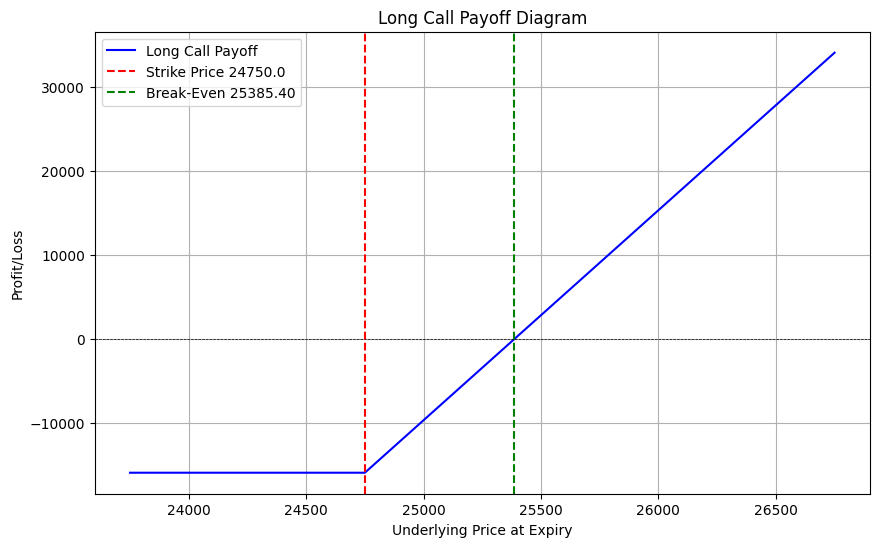

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting the payoff graph using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Long Call Payoff', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(strike, color='red', linestyle='--', label=f'Strike Price {strike}', linewidth=1.5)
plt.axvline(BEP, color='green', linestyle='--', label=f'Break-Even {BEP:.2f}', linewidth=1.5)

# Add labels and title
plt.title('Long Call Payoff Diagram')
plt.xlabel('Underlying Price at Expiry')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
